In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/Datasets/Dataset.zip -d /content

# WGAN with Gradient Penalty

In [ ]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
!pip install torchmetrics
from torchmetrics.classification import BinaryAccuracy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Generator and Noise

In [ ]:
class Generator(nn.Module):

    def __init__(self, z_dim=100, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, hidden_dim * 4, kernel_size=3, stride=2),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=3, stride=2),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=3, stride=2),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, im_chan, kernel_size=4, stride=2),
            nn.Tanh()
        )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)


def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

#### Discriminator

In [ ]:
class Critic(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            nn.Conv2d(im_chan, hidden_dim, 4, 2),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_dim, hidden_dim * 2, 4, 2),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_dim * 2, 1, 4, 3),
        )

    def forward(self, image):
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

In [ ]:
batch_size = 128

device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                transforms.Grayscale(num_output_channels=1),])

data = torchvision.datasets.ImageFolder('/content/Dataset',transform=transform)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

# Initialization

In [ ]:
z_dim = 100

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.0015, betas=(0.5, 0.999))
crit = Critic().to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=0.0012, betas=(0.5, 0.999))

## Gradient Penalty

In [ ]:
def get_gradient(crit, real, fake, eps):
    mixed_images = real * eps + fake * (1 - eps)
    mixed_scores = crit(mixed_images)
    return torch.autograd.grad(inputs=mixed_images,
                                   outputs=mixed_scores,
                                   grad_outputs=torch.ones_like(mixed_scores), 
                                   create_graph=True,
                                   retain_graph=True,)[0]

def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)    
    return torch.mean((gradient_norm - 1)**2)

def get_gen_loss(crit_fake_pred):
    return -1. * torch.mean(crit_fake_pred)

def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    return torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

metric = BinaryAccuracy().to(device)

## Training




Step 100: 
Generator loss: -1.2449825600162148
Critic loss: -6.005698860764503
Accuracy of critic 0.5078125


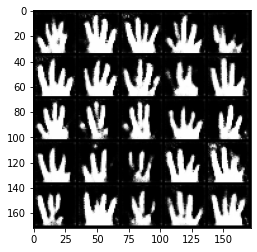

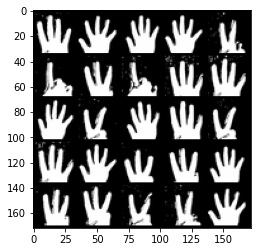

Step 200: 
Generator loss: -8.344382538795472
Critic loss: -5.202311878025535
Accuracy of critic 0.5


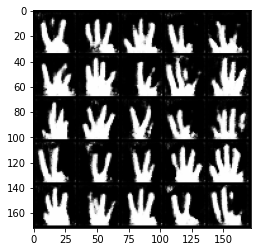

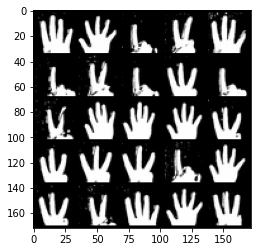

Step 300: 
Generator loss: -9.807900333404541
Critic loss: -3.858453330531715
Accuracy of critic 0.52734375


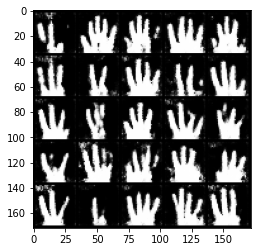

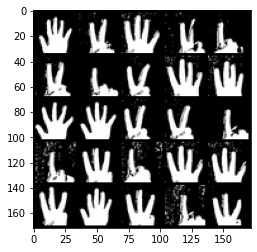

Step 400: 
Generator loss: -10.426889729499816
Critic loss: -3.2863149036765087
Accuracy of critic 0.5


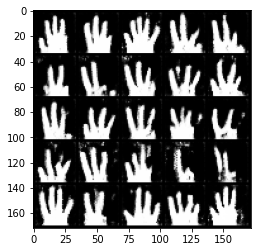

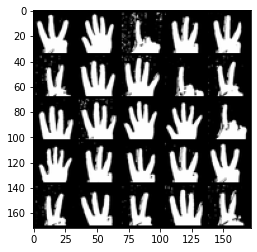

Step 500: 
Generator loss: -13.755739173889161
Critic loss: -4.341280861377714
Accuracy of critic 0.5


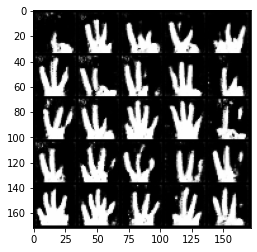

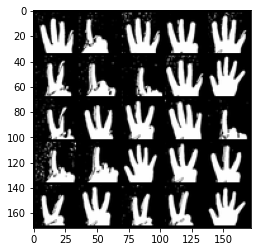

Step 600: 
Generator loss: -12.60079270362854
Critic loss: -5.172449635982514
Accuracy of critic 0.5


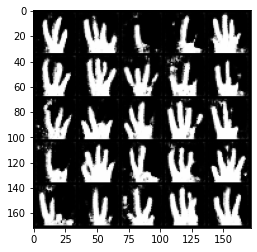

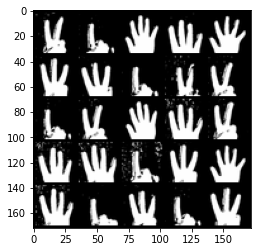

Step 700: 
Generator loss: -9.291928551197053
Critic loss: -5.701208507061004
Accuracy of critic 0.52734375


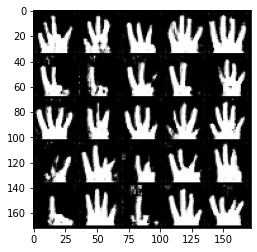

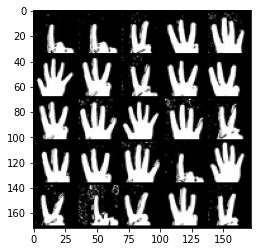

Step 800: 
Generator loss: -6.598747262358666
Critic loss: -6.3304095220565815
Accuracy of critic 0.515625


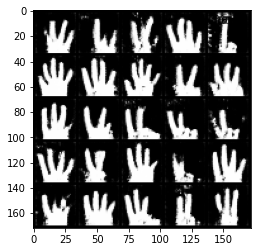

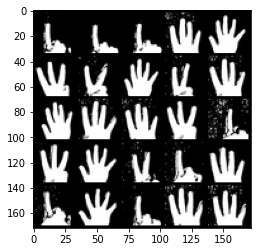

Step 900: 
Generator loss: -4.666675052791834
Critic loss: -7.284151717126374
Accuracy of critic 0.50390625


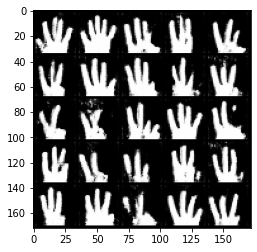

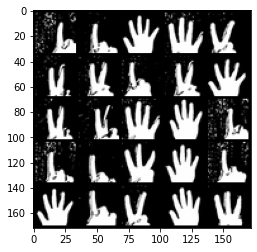

In [ ]:
Acc_epoch = list()
critic_losses = list()
generator_losses = list()

cur_step = 0
c_lambda = 10
n_epochs = 120
crit_repeats = 5
display_step = 100

for epoch in range(n_epochs):
    Acc = list()
    for real, _ in (dataloader):
        real = real.to(device)
        mean_iteration_critic_loss = 0

        for _ in range(crit_repeats): 
            # Updating the critic
            crit_opt.zero_grad()
            fake_noise = get_noise(len(real), z_dim, device=device)
            fake_images = gen(fake_noise)
            crit_fake_pred = crit(fake_images.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake_images.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)
            # average critic loss
            # Updating the gradients
            # Updating the optimizer
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            crit_loss.backward(retain_graph=True)
            crit_opt.step()

        critic_losses += [mean_iteration_critic_loss]
        # Updating the generator
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(len(real), z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()
        # Updating the weights
        # average generator loss
        gen_opt.step()
        generator_losses += [gen_loss.item()]
        # Accuracy calculation
        acc = metric(crit_fake_pred.to(device), torch.zeros(len(real), 1).to(device)) + metric(crit_real_pred.to(device), torch.ones(len(real), 1).to(device))
        acc = acc / 2
        Acc.append(acc.item())

        # Visualization
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: ")
            print(f"Generator loss: {gen_mean}")
            print(f"Critic loss: {crit_mean}")
            print('Accuracy of critic', acc.item())
            show_tensor_images(fake_images)
            show_tensor_images(real)
            num_examples = (len(generator_losses) // 20) * 20

        cur_step += 1

    Acc_epoch.append(sum(Acc) / len(Acc))

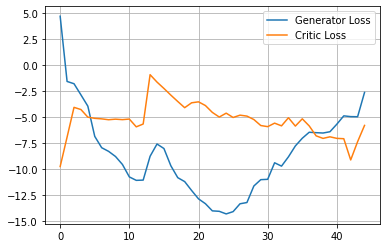

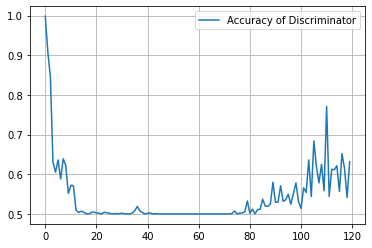

In [ ]:
plt.plot(range(num_examples // 20), torch.Tensor(generator_losses[:num_examples]).view(-1, 20).mean(1), label="Generator Loss")

plt.plot(range(num_examples // 20), torch.Tensor(critic_losses[:num_examples]).view(-1, 20).mean(1), label="Critic Loss")

plt.legend()
plt.grid()
plt.show()

plt.plot(Acc_epoch, label='Accuracy of Discriminator')
plt.legend()
plt.grid()
plt.show()